In [1]:
#| label: import
#| echo: false
#| include: true
#| code-fold: false

## General imports
import warnings
warnings.filterwarnings('ignore')

## Data manipulation imports
import pandas as pd
import numpy as np

## Display imports
from IPython.display import display, Markdown

## statmodels import
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.genmod.families.family as fam
from patsy import dmatrices

## Plot imports
import matplotlib.style as style
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5/2.5)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_theme()
sns.set_context(
    "paper", 
    rc={
        "figsize"       :   plt.rcParams['figure.figsize'],
        'font_scale'    :   1.25,
    }
)
height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0] / plt.rcParams['figure.figsize'][1] / 2

# Introduction
Did you ever dream to build your own fast API written in Python? 

[FastAPI](https://fastapi.tiangolo.com/) is a modern, high-performance web framework for building APIs with Python. It blends the ease of use of Python with exceptional speed, making it an ideal choice for developing robust and efficient web applications. Whether you're crafting a simple REST API or a complex microservices architecture, FastAPI will help you with that. 

The installation of FastAPI is very simple and it involves the installation of two packages: (1) FastAPI and (2) Uvicorn. The first one is the framework itself and the second one is the server that will run the API.

```bash
pip install fastapi
pip install "uvicorn[standard]"
```

In this tutorial, we will build a simple API that will allow us to perform basic CRUD (Create, Read, Update, Delete) operations on a database. The access to the database will be done by SQLAlchemy, which is a Python SQL toolkit for SQL databases. By the means of fastAPI, we will also provide a documentation of the API, which will be accessible through a web browser. 

In [2]:
#| output: false
#| echo: false
#| code-fold: false

try:
    # helper function for reading datasets with proper separator
    def get_dataset(url):
        if url[-3:] != "csv":
            print(
                """"
                The data set URL has no proper 'csv' extension. 
                Reading the dataset might not have worked as expected.
                Please check the dataset link and adjust pandas' 
                read_csv() parameters accordingly.
                """
            )
        data = pd.read_csv(
            url, 
            sep = ",", 
            on_bad_lines = 'warn', 
            encoding_errors = 'ignore', 
            low_memory = False,
        )
        # if dataframe only has one column or less the data is not comma separated, use ";" instead
        if data.shape[1] <= 1:
            data = pd.read_csv(
                url, 
                sep=';', 
                on_bad_lines='warn', 
                encoding_errors='ignore', 
                low_memory=False,
            )
            if data.shape[1] <= 1:
                print("""
                The data wasn't imported properly. 
                Very likely the correct separator couldn't be found.
                Please check the dataset manually and adjust the code.
                """)
        return data

    df = (
        get_dataset(
            'https://www.web.statistik.zh.ch/ogd/data/KANTON_ZUERICH_286.csv'
        )
        .rename(
            columns = {
                'GEBIET_NAME'       :   'Municipality',
                'INDIKATOR_JAHR'    :   'Year',
                'INDIKATOR_VALUE'   :   'Tax',
            }
        )
        .assign(
            Year = lambda df: pd.to_datetime(df['Year'], format='%Y').dt.year,
            IncomeTax = lambda df: df['Tax'].astype(int),   
        )
    )

    df.to_parquet(
        '../../data/IncomeTax.parquet',
    )
except:
    df = pd.read_parquet(
        '../../data/IncomeTax.parquet',
    )

# Data
In this post we are going to talk about taxes. More specifically, we will focus on the tax system of Switzerland. Switzerland's unique tax system is characterized by its federal structure, granting significant fiscal autonomy to its municipalities (cities) and cantons (states). This system encourages competition among cantons and municipalities while also fostering a sense of local ownership and control over financial matters. As a result, Switzerland's tax landscape is complex, diverse, and reflective of the nation's commitment to decentralized governance.

In [3]:
#| echo: false

display(
    Markdown(
        f"We have data from {df.Municipality.nunique()} municipalities during the period between {df.Year.min()}-{df.Year.max()}. " + " "
        f"The data presents the mean wealth per municipality and year."
    )
)

We have data from 201 municipalities during the period between 1990-2022.  The data presents the mean wealth per municipality and year.

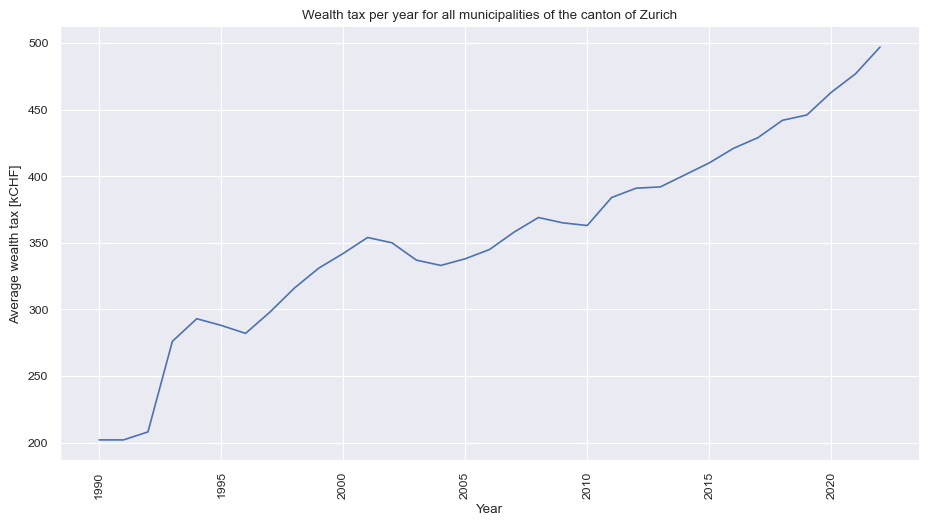

In [4]:
#| label: fig-income_tax_zurich
#| include: false
#| output: true
#| echo: false
#| fig-cap: Average wealth of the canton of Zurich per year. A positive trend can be observed for the given time period between 1990 and 2022.

df_plot = (
    df
    .query(
        'Municipality.str.contains("Kanton")'
    )
)

sns.relplot(
    data = df_plot,
    x = 'Year',
    y = 'Tax',
    height = height,
    aspect = aspect * 1.5,
    kind = 'line',
)
plt.title('Wealth tax per year for all municipalities of the canton of Zurich')
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Average wealth tax [kCHF]')
plt.show()

@fig-income_tax_zurich shows a positive trend of average wealth in the canton of Zurich per year. The mean value constantly increased from 1990 to 2022. It is quite impressive that the average value is more than doubled in 32 years (considering very low inflation in Switzerland).

# Database
The data is stored in a database, a crucial endeavor that lays the foundation for simulating a dynamic production environment. We are going to use `sqlalchemy`: a remarkable tool empowers us to seamlessly alter the connection string enabling effortlessly establishment of connections across a diverse database types. 

First, the connection is defined by `sqlalchemy.create_engine()` and subsequently used in order to save the data to the database using pandas method `to_sql()`.

In [7]:
#| label: lst-database
#| code-fold: false
#| echo: true
#| output: false

import statsmodels.api as sm
from sqlalchemy import create_engine

# Create a connection to the database
engine = create_engine(              
    ## Path to database                     
    'sqlite:///../../data/FastAPI.db',      # <1>
)

## Create a table in new database
(
    df
    [['Municipality','Year','Tax']]
    .to_sql(
        name = 'fastapi',
        con = engine,
        if_exists = 'replace',
        index = False,
    )
);

After the creation of the `fastapi` table within the `FastAPI` database, we can continue with the creation of the API.

# Building our API
The building blocks of our API-service consists of basic CRUD (Create, Read, Update, Delete) operations as follows:

| Function (api endpoints)            | Description                                                     |
|-------------------------------------|-----------------------------------------------------------------|
| Get Data for a Given Year           | Returns wealth tax data for a given year.                       |
| Get Data for a Given Municipality   | Returns wealth tax data for a given municipality.               |
| Get Data for a Given District       | Returns wealth tax data for a given district.                   |
| Get Data for the Canton             | Returns wealth tax data for the entire canton.                  |
| Create New Entry                    | Creates a new entry in the wealth tax table.                    |
| Update Tax Entry                    | Updates the wealth tax value for a given municipality and year. |
| Update Year Entry                   | Updates the year value for a given municipality and year.       |
| Delete Entry                        | Deletes an entry from the wealth tax table.                     |

Our api-service is going to use no authentication for its endpoints. This is not recommended for production environments. However, it is a good starting point for learning purposes. 

Next, we are going to discuss and review portions of the code that are relevant for the creation of the API. The complete code can be found in the end of the article.

**Note:** An API endpoint serves as a specific URL or URI through which an application can interact with a particular functionality or resource on a server. It acts as a gateway, allowing clients to send requests for data or perform actions, while the server processes these requests and sends back the appropriate response. Here's an example of an API endpoint for a hypothetical online bookstore:

> API Base URL: https://api.bookstore.com

Example Endpoints:

> Action:       Retrieve Book Information
> Endpoint:     /books/{book_id}  
> Description:  Retrieves detailed information about a specific book.  
> Example URL:  https://api.bookstore.com/books/123  

## Setting Up the Project
To begin, we import the necessary libraries including `pandas`, `pydantic`, and `fastapi`. We're also using `sqlalchemy` for database interactions. Our code starts by creating a database connection using the SQLAlchemy library. We've chosen an SQLite database for this demonstration. However, you can use any database you like. 

```python
import pandas as pd

from pydantic import BaseModel, Field
from fastapi import FastAPI, HTTPException, 

from sqlalchemy import create_engine, MetaData, Table, select, insert, update, delete

## Create a metadata object
metadata = MetaData()

## Create a connection to the database
engine = create_engine(              
    ## Path to database                     
    'sqlite:///../../data/FastAPI.db',      # <1>
)

## Reflect census table from the engine: census
fastapi = Table(
    "fastapi", 
    metadata,
    autoload_with = engine,
)

```

Moreover, we create a utility function to connect to the database and return a json-style format. This function will be used in the endpoints to fetch data from the database and return the dictionary, which will be converted to json format by FastAPI. 

```python
## Helper function to fetch data
def fetch_return_dict(
        stmt, 
        engine = engine,
    ) -> dict:
    """
    Utility function to convert sql query results to dict via pandas dataframe
    """
    ## Create a connection to the database
    connection = engine.connection()
    data = connection.execute(stmt).fetchall()
    connection.close()

    return (
        pd.DataFrame(
            data = data
        )
        .to_dict(
            orient = "records", 
        )
    )
```

## FastAPI Object
We instantiate a FastAPI app object with a title, description, and version. This app will serve as the backbone of our API. The description section contains details about the API and apear in the documentation. 

```python
## Instantiate a FastAPI object
app = FastAPI(
    title           =   "API Service",
    description     =   """
    ...
    Add more description here
    ...
    """,
    version         =   "0.0.1",
)
```

## Defining the Data Model
FastAPI encourages the use of [Pydantic](https://docs.pydantic.dev/latest/) models for data validation and serialization. Pydantic is a Python library that simplifies the process of data validation and settings management in applications. It allows you to define data schemas using Python data classes with type annotations, and automatically validates and parses incoming data according to these schemas.

We've defined `IncomeTaxModel`, `MunicipalityDataOut`, `IncomeTaxDataOut`, and `YearDataOut` as Pydantic models (`BaseModel` and type annotation) to structure the data that will be sent and received by the API endpoints.

```python
class TaxModel(BaseModel):
    Municipality    :   str    =  Field("Name of item")
    Tax             :   int    =  Field("Average tax for a given year")
    Year            :   int    =  Field("Year of meassurement")

class MunicipalityDataOut(BaseModel):
    Tax             :   int    =  Field("Average tax for a given year")
    Year            :   int    =  Field("Year of meassurement")
    
class TaxDataOut(BaseModel):
    Municipality    :   str    =  Field("Name of item")
    Year            :   int    =  Field("Year of meassurement")

class YearDataOut(BaseModel):
    Municipality    :   str    =  Field("Name of item")
    Tax             :   int    =  Field("Average tax for a given year")
```


## Building API Endpoints
We proceed to define various API endpoints using FastAPI's decorators. These endpoints cover different scenarios, from fetching data for a specific year to creating and updating entries in the database. Each endpoint corresponds to a specific HTTP method (GET, POST, PUT, DELETE) and handles specific types of requests.

For instance, the `index` route handles a basic GET request and returns all data from the database, ordered by the year. The `get_data_of_year` route fetches data for a given year, while `get_municipality_data` and `get_district_data` retrieve data for specific municipalities or districts, respectively. Additionally, the `create_new_entry`, `update_tax_entry`, `update_year_entry`, and `delete_tax_entry` routes allow for CRUD (Create, Read, Update, Delete) operations on the data.

Next, I will show you the incomplete code for the endpoints (the complete code can be found in the end of the article):

```python
@app.get("/")
def index():
    return something

## Create a route to return data for a given year
@app.get("/year/{year}")
def get_data_of_year():
    return something

## Create a route to return data for a given city
@app.get("/municipality/{municipality}")
def get_municipality_data():
    return something

## Create a route to return data for a given district
@app.get("/district/{district}")
def get_district_data():
    return something

## Create a route to return data from the canton
@app.get("/canton/")
def get_canton_data():
    return something

## Create a new entry
@app.post('/entry/{municipality}/{year}/{tax}')
def create_new_entry():
    return something

## Update an income tax entry
@app.put("/update_tax/{municipality}/{year}/{tax}")
def update_tax_entry():
    return something
    
## update year entry
@app.put("/update_year/{municipality}/{year_old}/{year_new}")
def update_year_entry():
    return something

@app.delete("/delete/{municipality}/{year}/{tax}")
def delete_tax_entry():
    return something
```

The components of the the fastapi endpoints are as follows:

1.  Decorators are used to define the route of each endpoints and the HTTP-method. 
2.  Type annotation of the parameters allows the definition and validation of the data type of the parameters. 

## Error Handling
The code also incorporates error handling. For instance, if a user attempts to create a new entry that already exists in the database, an HTTPException with an appropriate status code and detail message is raised. Similarly, error handling is employed for updating and deleting entries that don't exist in the database. The following codes are use: 400 for Bad Request, 404 for Not Found, and 500 for Internal Server Error. More information can be found [here](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status). 

The implementation of error handling is done by `raise HTTPException()` as follows:

```python
## Create a index route
@app.get("/")
def index() -> list[IncomeTaxModel]:
    
    ...

    result = fetch_return_dict(stmt)

    if result:
        return result
    else:
        raise HTTPException(
            status_code = 404, 
            detail = f"Item not found",
        )
```

# API-Documentation
FastAPI provides a built-in documentation system that is automatically generated based on the API's metadata and doc-strings provided. The documentation is accessible at the `/docs` and `/redoc` endpoint (we focus in this tutorial on `/docs` page only). The documentation is interactive and allows users to test the API directly from the browser. The documentation is also available in JSON format at the `/openapi.json` endpoint.

::: {#fig-docpages layout-row=2}

![API docs: API description and methods](../imgs/api_doc_11.png){#fig-api1}

![API docs: Data schema description](../imgs/api_doc_22.png){#fig-api2}

API docs page for the API service. The documentation is interactive and allows users to test the API directly from the browser.
:::

## Conclusion
In this article, we've walked through the creation of a FastAPI web service for accessing income tax data. We've covered the setup process, defining data models, creating API endpoints, and handling database interactions. FastAPI's intuitive syntax and powerful features make it a fantastic choice for building efficient and robust APIs. This project serves as a foundation, demonstrating how to construct APIs that facilitate data retrieval and manipulation, crucial tasks in today's data-centric world.

Overall, this FastAPI-based web service exemplifies the elegance and utility of modern Python frameworks in building APIs that bridge the gap between data and applications.

# Appendix: Complete code

In [8]:
#| output: asis
#| echo: false
#| include: true
#| code-fold: false

with open('../utils/main.py', 'r') as file:
    code = file.read()
    
print(
    "```python" + "\n" + 
    code +
    "```"
)

```python
import pandas as pd

from pydantic import BaseModel, Field
from fastapi import FastAPI, HTTPException

from sqlalchemy import create_engine, MetaData, Table, select, insert, update, delete

## Create a metadata object
metadata = MetaData()

## Create a connection to the database
engine = create_engine(              
    ## Path to database                     
    'sqlite:///../../data/FastAPI.db',      # <1>
)

## Reflect census table from the engine: census
fastapi = Table(
    "fastapi", 
    metadata,
    autoload_with = engine,
)

## Helper function to fetch data
def fetch_return_dict(
        stmt, 
        engine = engine,
    ) -> dict:
    """
    Utility function to convert sql query results to dict via pandas dataframe
    """
    ## Create a connection to the database
    connection = engine.connect()
    data = connection.execute(stmt).fetchall()
    connection.close()

    return (
        pd.DataFrame(
            data = data
        )
        .to_dict(
       